🚀 [Step 1] 입력 피처 추출 및 전처리 중...

🔍 [Step 2] 그리드 서치 전(Baseline) 모델 성능 확인 중...
📊 그리드 서치 전 Mean NDCG: 0.9365

🚀 [Step 3] 그리드 서치로 최적 파라미터 탐색 중...
✨ 최적 조합 발견: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500, 'num_leaves': 20}

📊 [결과 비교]
1. 그리드 서치 전 NDCG: 0.9365
2. 그리드 서치 후 NDCG: 0.9382
🔥 성능 향상: 0.19%


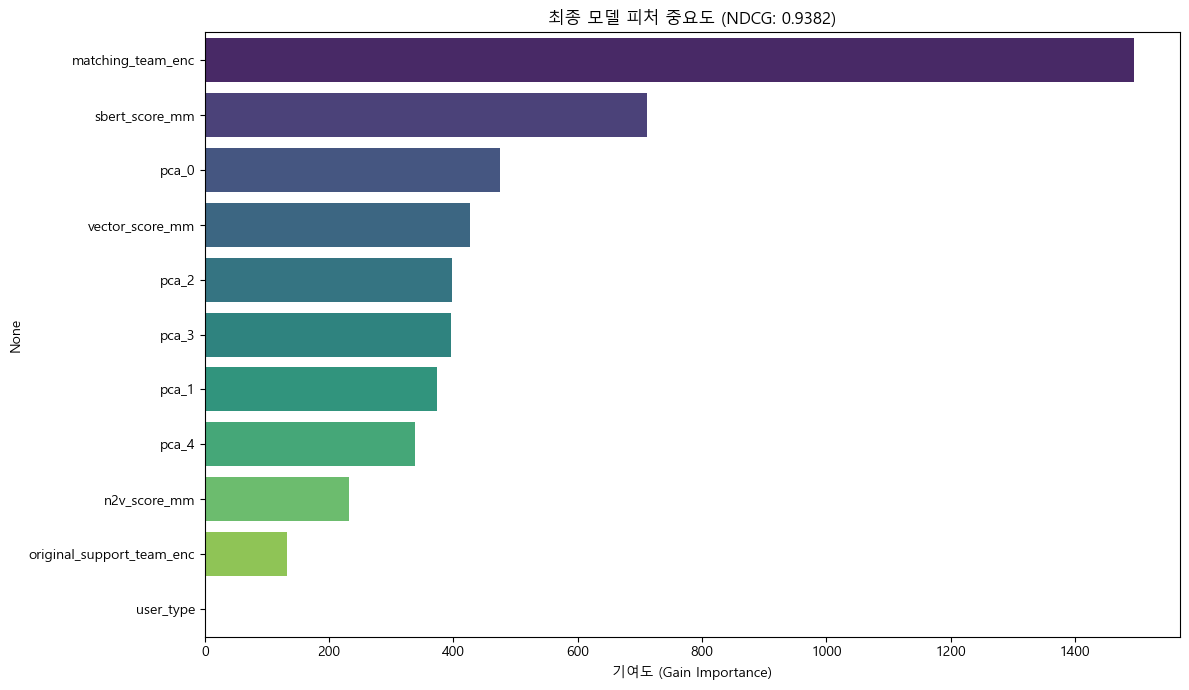

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GroupShuffleSplit, ParameterGrid
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import ndcg_score
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ------------------------------------------------------------
# 0) 데이터 로드 및 전처리
# ------------------------------------------------------------
warnings.filterwarnings("ignore")
plt.rcParams['font.family'] = 'Malgun Gothic'

df = pd.read_csv(".\\csv_파일\\final_data.csv")
df["relevance"] = df.groupby("query")["llm_rank"].transform(lambda s: s.max() - s + 1)

# 데이터 분할 (질문 단위 8:2)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df["query"]))
train_df, test_df = df.iloc[train_idx].copy(), df.iloc[test_idx].copy()

# ------------------------------------------------------------
# 1) 입력 피처(Input Features) 생성
# ------------------------------------------------------------
print("🚀 [Step 1] 입력 피처 추출 및 전처리 중...")

# (1) query_emb (SBERT -> PCA 5차원)
sbert = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS")
train_qs = train_df["query"].unique()
test_qs = test_df["query"].unique()
train_emb_raw = sbert.encode(train_qs)
test_emb_raw = sbert.encode(test_qs)

pca = PCA(n_components=5, random_state=42)
train_pca = pca.fit_transform(train_emb_raw)
test_pca = pca.transform(test_emb_raw)

train_q_map = {q: v for q, v in zip(train_qs, train_pca)}
test_q_map = {q: v for q, v in zip(test_qs, test_pca)}
pca_cols = [f"pca_{i}" for i in range(5)]

# (2) 피처 변환 및 인코딩
for d, q_map in [(train_df, train_q_map), (test_df, test_q_map)]:
    d[pca_cols] = pd.DataFrame(d["query"].map(q_map).tolist(), index=d.index)
    d["user_type"] = d["user_type"].astype(int)
    
    le_team = LabelEncoder()
    d["original_support_team_enc"] = le_team.fit_transform(d["original_support_team"].astype(str))
    d["matching_team_enc"] = le_team.fit_transform(d["matching_team"].astype(str))
    
    score_cols = ["sbert_score", "n2v_score", "vector_score"]
    scaler = MinMaxScaler()
    d[[f"{c}_mm" for c in score_cols]] = scaler.fit_transform(d[score_cols])

input_features = ["user_type", "original_support_team_enc", "matching_team_enc"] + \
                    pca_cols + [f"{c}_mm" for c in score_cols]

X_train, y_train = train_df[input_features], train_df["relevance"]
X_test, y_test = test_df[input_features], test_df["relevance"]

cat_features = ["user_type", "original_support_team_enc", "matching_team_enc"]
for c in cat_features:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

group_train = train_df.groupby("query").size().values
group_test = test_df.groupby("query").size().values

# ------------------------------------------------------------
# 2) [추가] 그리드 서치 전 Baseline 성능 확인
# ------------------------------------------------------------
print("\n🔍 [Step 2] 그리드 서치 전(Baseline) 모델 성능 확인 중...")

# 초기 기준 파라미터
baseline_params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "learning_rate": 0.05,
    "max_depth": 5,
    "n_estimators": 300,
    "random_state": 42,
    "importance_type": "gain",
    "verbosity": -1
}

baseline_model = lgb.LGBMRanker(**baseline_params)
baseline_model.fit(X_train, y_train, group=group_train)

baseline_preds = baseline_model.predict(X_test)
test_df["baseline_preds"] = baseline_preds
baseline_ndcg = np.mean([ndcg_score([sub["relevance"]], [sub["baseline_preds"]]) 
                        for _, sub in test_df.groupby("query") if len(sub) > 1])

print(f"📊 그리드 서치 전 Mean NDCG: {baseline_ndcg:.4f}")

# ------------------------------------------------------------
# 3) 그리드 서치 (Grid Search) 적용
# ------------------------------------------------------------
print("\n🚀 [Step 3] 그리드 서치로 최적 파라미터 탐색 중...")
param_grid = {
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'n_estimators': [200, 500],
    'num_leaves': [20, 31, 50]
}

best_score = -1
best_params = None

for params in ParameterGrid(param_grid):
    model = lgb.LGBMRanker(**params, random_state=42, importance_type='gain', verbosity=-1)
    model.fit(X_train, y_train, group=group_train)
    
    val_preds = model.predict(X_test)
    test_df["temp_preds"] = val_preds
    cur_ndcg = np.mean([ndcg_score([sub["relevance"]], [sub["temp_preds"]]) 
                        for _, sub in test_df.groupby("query") if len(sub) > 1])
    
    if cur_ndcg > best_score:
        best_score = cur_ndcg
        best_params = params

print(f"✨ 최적 조합 발견: {best_params}")

# ------------------------------------------------------------
# 4) 최종 모델 학습 및 결과 비교
# ------------------------------------------------------------
final_model = lgb.LGBMRanker(**best_params, random_state=42, importance_type='gain')
final_model.fit(X_train, y_train, group=group_train)

test_preds = final_model.predict(X_test)
test_df["final_preds"] = test_preds
final_ndcg = np.mean([ndcg_score([sub["relevance"]], [sub["final_preds"]]) 
                    for _, sub in test_df.groupby("query") if len(sub) > 1])

print("\n" + "="*45)
print(f"📊 [결과 비교]")
print(f"1. 그리드 서치 전 NDCG: {baseline_ndcg:.4f}")
print(f"2. 그리드 서치 후 NDCG: {final_ndcg:.4f}")
print(f"🔥 성능 향상: {((final_ndcg - baseline_ndcg) / baseline_ndcg * 100):.2f}%")
print("="*45)

# 피처 중요도 시각화
plt.figure(figsize=(12, 7))
feat_imp = pd.Series(final_model.feature_importances_, index=input_features).sort_values(ascending=False)
sns.barplot(x=feat_imp, y=feat_imp.index, palette='viridis')
plt.title(f"최종 모델 피처 중요도 (NDCG: {final_ndcg:.4f})")
plt.xlabel("기여도 (Gain Importance)")
plt.tight_layout()
plt.show()

🚀 [Step 1] 입력 피처 추출 및 전처리 중...

🔍 [Step 2] 그리드 서치 전(Baseline) 모델 성능 확인 중...
📊 그리드 서치 전 Mean NDCG: 0.9432

🚀 [Step 3] 그리드 서치로 최적 파라미터 탐색 중...
✨ 최적 조합 발견: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500, 'num_leaves': 50}

📊 [결과 비교]
1. 그리드 서치 전 NDCG: 0.9432
2. 그리드 서치 후 NDCG: 0.9492
🔥 성능 향상: 0.64%


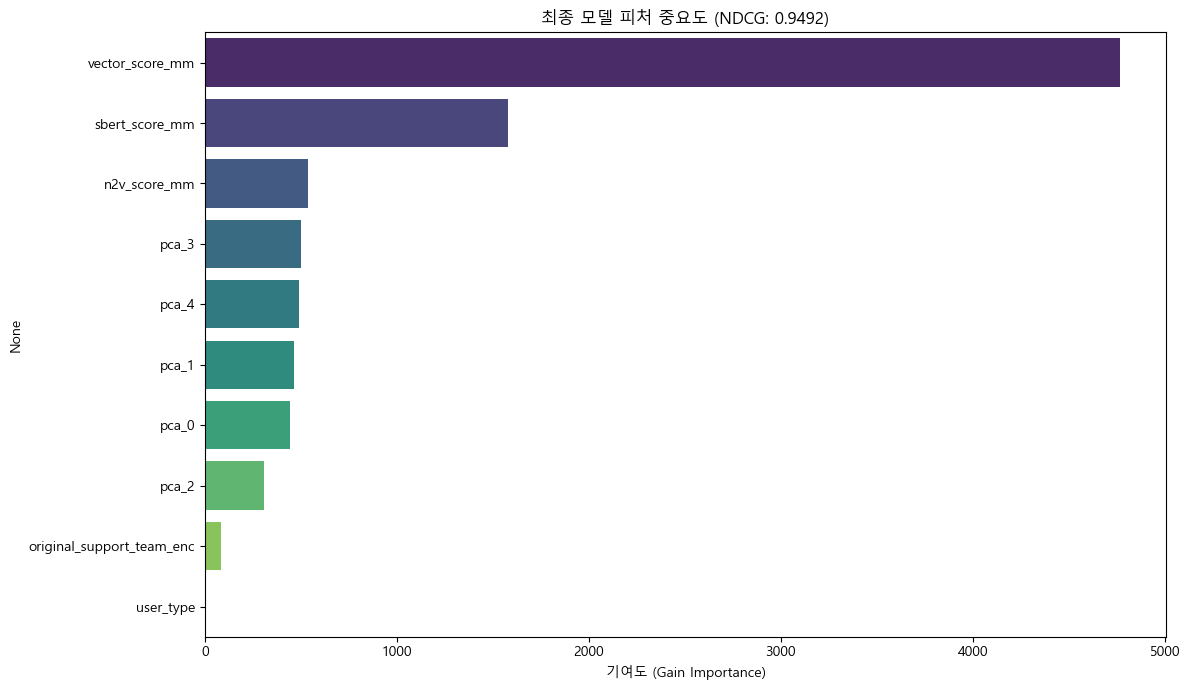

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GroupShuffleSplit, ParameterGrid
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import ndcg_score
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ------------------------------------------------------------
# 0) 데이터 로드 및 전처리
# ------------------------------------------------------------
warnings.filterwarnings("ignore")
plt.rcParams['font.family'] = 'Malgun Gothic'

df = pd.read_csv(".\\csv_파일\\final_data.csv")

# llm_rank가 0인 데이터(실패군) 제외 처리 (선택 사항이나 권장함)
df = df[df["llm_rank"] > 0].copy()

# relevance 생성 (순위 1위가 가장 높은 점수를 갖도록)
df["relevance"] = df.groupby("query")["llm_rank"].transform(lambda s: s.max() - s + 1)

# 데이터 분할 (질문 단위 8:2)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df["query"]))
train_df, test_df = df.iloc[train_idx].copy(), df.iloc[test_idx].copy()

# ------------------------------------------------------------
# 1) 입력 피처(Input Features) 생성
# ------------------------------------------------------------
print("🚀 [Step 1] 입력 피처 추출 및 전처리 중...")

# (1) query_emb (SBERT -> PCA 5차원)
sbert = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS")
train_qs = train_df["query"].unique()
test_qs = test_df["query"].unique()
train_emb_raw = sbert.encode(train_qs)
test_emb_raw = sbert.encode(test_qs)

# PCA는 Train 데이터로만 학습(fit)
pca = PCA(n_components=5, random_state=42)
train_pca_vals = pca.fit_transform(train_emb_raw)
test_pca_vals = pca.transform(test_emb_raw)

train_q_map = {q: v for q, v in zip(train_qs, train_pca_vals)}
test_q_map = {q: v for q, v in zip(test_qs, test_pca_vals)}
pca_cols = [f"pca_{i}" for i in range(5)]

# PCA 결과 반영
train_df[pca_cols] = pd.DataFrame(train_df["query"].map(train_q_map).tolist(), index=train_df.index)
test_df[pca_cols] = pd.DataFrame(test_df["query"].map(test_q_map).tolist(), index=test_df.index)

# (2) 피처 변환 및 인코딩 (데이터 누수 방지 로직)
train_df["user_type"] = train_df["user_type"].astype(int)
test_df["user_type"] = test_df["user_type"].astype(int)

# 팀 인코딩 (Train 기준)
le_team = LabelEncoder()
train_df["original_support_team_enc"] = le_team.fit_transform(train_df["original_support_team"].astype(str))
team_mapping = {cls: i for i, cls in enumerate(le_team.classes_)}
test_df["original_support_team_enc"] = test_df["original_support_team"].astype(str).map(team_mapping).fillna(-1).astype(int)

# 점수 스케일링 (Train 기준)
score_cols = ["sbert_score", "n2v_score", "vector_score"]
scaler = MinMaxScaler()
train_df[[f"{c}_mm" for c in score_cols]] = scaler.fit_transform(train_df[score_cols])
test_df[[f"{c}_mm" for c in score_cols]] = scaler.transform(test_df[score_cols])

# [핵심 수정] matching_team_enc를 제외한 최종 입력 피처 리스트
input_features = ["user_type", "original_support_team_enc"] + \
                 pca_cols + [f"{c}_mm" for c in score_cols]

X_train, y_train = train_df[input_features], train_df["relevance"]
X_test, y_test = test_df[input_features], test_df["relevance"]

# 범주형 피처 설정 (matching_team_enc 제외됨)
cat_features = ["user_type", "original_support_team_enc"]
for c in cat_features:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

group_train = train_df.groupby("query").size().values
group_test = test_df.groupby("query").size().values

# ------------------------------------------------------------
# 2) 그리드 서치 전 Baseline 성능 확인
# ------------------------------------------------------------
print("\n🔍 [Step 2] 그리드 서치 전(Baseline) 모델 성능 확인 중...")

baseline_params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "learning_rate": 0.05,
    "max_depth": 5,
    "n_estimators": 300,
    "random_state": 42,
    "importance_type": "gain",
    "verbosity": -1
}

baseline_model = lgb.LGBMRanker(**baseline_params)
baseline_model.fit(X_train, y_train, group=group_train)

baseline_preds = baseline_model.predict(X_test)
test_df["baseline_preds"] = baseline_preds
baseline_ndcg = np.mean([ndcg_score([sub["relevance"]], [sub["baseline_preds"]]) 
                        for _, sub in test_df.groupby("query") if len(sub) > 1])

print(f"📊 그리드 서치 전 Mean NDCG: {baseline_ndcg:.4f}")

# ------------------------------------------------------------
# 3) 그리드 서치 (Grid Search) 적용
# ------------------------------------------------------------
print("\n🚀 [Step 3] 그리드 서치로 최적 파라미터 탐색 중...")
param_grid = {
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'n_estimators': [200, 500],
    'num_leaves': [20, 31, 50]
}

best_score = -1
best_params = None

for params in ParameterGrid(param_grid):
    model = lgb.LGBMRanker(**params, random_state=42, importance_type='gain', verbosity=-1)
    model.fit(X_train, y_train, group=group_train)
    
    val_preds = model.predict(X_test)
    test_df["temp_preds"] = val_preds
    cur_ndcg = np.mean([ndcg_score([sub["relevance"]], [sub["temp_preds"]]) 
                        for _, sub in test_df.groupby("query") if len(sub) > 1])
    
    if cur_ndcg > best_score:
        best_score = cur_ndcg
        best_params = params

print(f"✨ 최적 조합 발견: {best_params}")

# ------------------------------------------------------------
# 4) 최종 모델 학습 및 결과 비교
# ------------------------------------------------------------
final_model = lgb.LGBMRanker(**best_params, random_state=42, importance_type='gain')
final_model.fit(X_train, y_train, group=group_train)

test_preds = final_model.predict(X_test)
test_df["final_preds"] = test_preds
final_ndcg = np.mean([ndcg_score([sub["relevance"]], [sub["final_preds"]]) 
                    for _, sub in test_df.groupby("query") if len(sub) > 1])

print("\n" + "="*45)
print(f"📊 [결과 비교]")
print(f"1. 그리드 서치 전 NDCG: {baseline_ndcg:.4f}")
print(f"2. 그리드 서치 후 NDCG: {final_ndcg:.4f}")
print(f"🔥 성능 향상: {((final_ndcg - baseline_ndcg) / baseline_ndcg * 100):.2f}%" if baseline_ndcg > 0 else "0%")
print("="*45)

# 피처 중요도 시각화
plt.figure(figsize=(12, 7))
feat_imp = pd.Series(final_model.feature_importances_, index=input_features).sort_values(ascending=False)
sns.barplot(x=feat_imp, y=feat_imp.index, palette='viridis')
plt.title(f"최종 모델 피처 중요도 (NDCG: {final_ndcg:.4f})")
plt.xlabel("기여도 (Gain Importance)")
plt.tight_layout()
plt.show()